### Задача
Чем активнее пользователи прилодения – тем выше нагрузка на сервера. И в последнее время всё чаще приходят жалобы, что приложение подвисает. Необходимо спрогнозировать, как изменится активность пользователей в течение ближайшего месяца.

1. Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
2. Постройте модель и провалидируйте её. Хватает ли у нас данных для бэккастинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
3. Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если видите какие-то важные ограничения по выводу – не забудьте их тоже указать.

### Основные параметры:
1. Нагрузка на сервер на прямую зависит от ежедневного количества действий/запросов (просмотры и лайки) и ежедневной активной аудитории ленты новостей и сообщений. У нас в день может быть большое количество уникальных пользователей, но они могут быть малоактивны. Но именно их взаимодействие с сервисом и является главным фактором нагрузки на сервера. поэтому будем прогнозировать метрику количество действий в день.
2. Имеем информацию за 9 недель наблюдений с 2023-06-03 по 2023-08-08. Сезонность - 1 неделя. Для тестирования прогноза модели необходимо разбить имеющиеся данные на 2 группы: тестовую и тренировочную, при чем тестовая группа должна составлять от 10% до 30% от общего количества. В таком случае принимаем в соотношении 6 недель/3 недели тренировочная группа с 2023-06-07 по 2023-07-18, тестовая группа с 2023-07-19 по 2023-08-08.
3. Чтобы выполнить беккастинг на 1 месяц не хватает данных. Можем выполнить на 3 недели.
4. Дополнительной информации о регрессорах не имеем, не будем учитывать.

In [14]:
#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний

In [15]:
#коннект к базе данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [16]:
q = """
SELECT toDate(time) AS day,
    count(action) AS count_actions
FROM simulator_20230720.feed_actions
    full join 
    simulator_20230720.message_actions
    using (user_id)
WHERE toDate(time) between toDate('2023-06-07') and toDate('2023-08-08')
GROUP BY day
ORDER BY day
"""

activity = ph.read_clickhouse(query=q, connection=connection)
activity.head(7)

,day,count_actions
0,2023-06-07,11526051
1,2023-06-08,10742321
2,2023-06-09,11033173
3,2023-06-10,12157657
4,2023-06-11,11982134
5,2023-06-12,15338850
6,2023-06-13,13514747


In [17]:
#зададим шаблон для seaborn
sns.set(rc={'figure.figsize':(20,6)}, style="whitegrid")

<Axes: xlabel='day', ylabel='count_actions'>

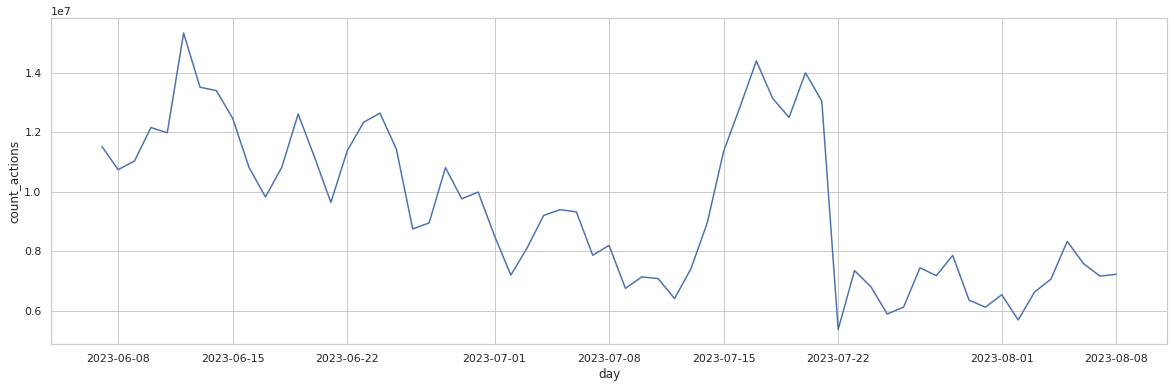

In [18]:
sns.lineplot(x='day', y='count_actions', data=activity)

### Строим модель MAP на тренировочной группе

In [19]:
actions_train = activity.query("day <= '2023-07-18'")
actions_test = activity.query("day > '2023-07-18'")

In [20]:
# Определяем параметры модели
dlt_map = DLT(response_col="count_actions", #название колонки с метрикой
          date_col="day", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2023-09-06 09:29:53 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [21]:
# Обучаем модель:
dlt_map.fit(actions_train)

2023-09-06 09:29:56 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


In [22]:
# прогнозируем
predicted_df_map = dlt_map.predict(df=actions_test, decompose=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

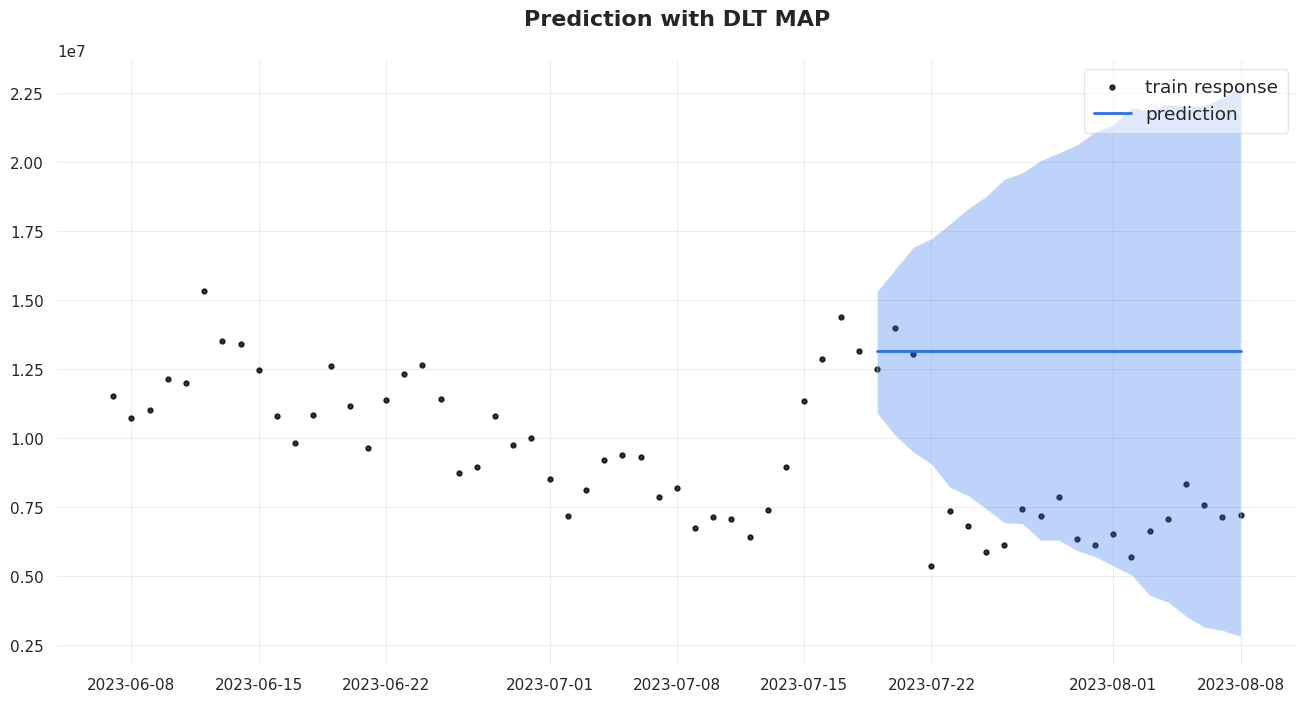

In [23]:
# Рисуем прогноз
_ = plot_predicted_data(activity, #изначальные данные
                        predicted_df_map, #датафрейм с предсказаниями
                        "day", #колонка со временем
                        'count_actions', #колонка со значениями временного ряда
                        title='Prediction with DLT MAP') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

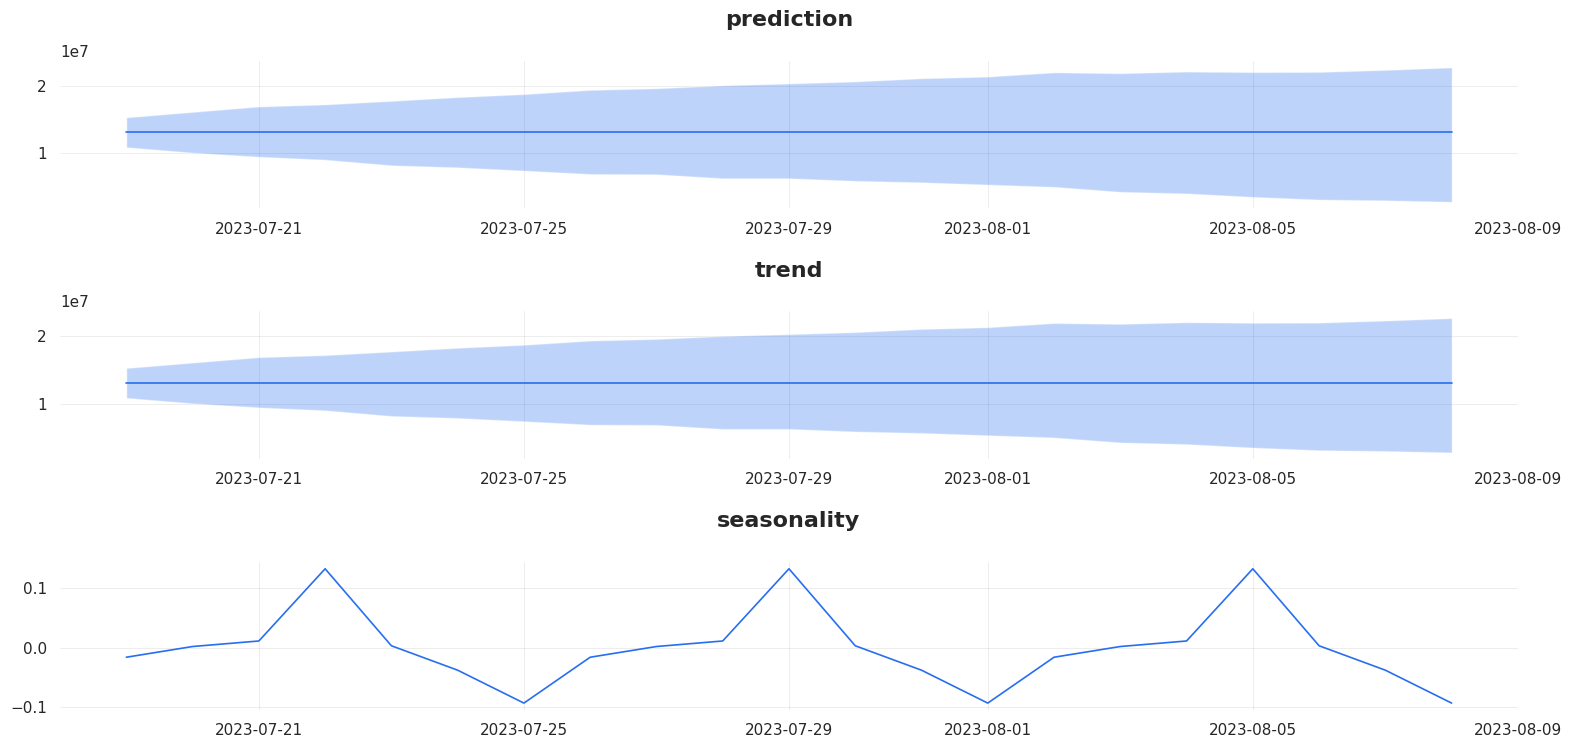

In [24]:
_ = plot_predicted_components(predicted_df_map, 
                              "day", 
                              plot_components=['prediction', 'trend', 'seasonality'])

## Вывод по модели MAP
Согласно графику, предсказание на 3 недели довольно неплохо ложится на тестовую группу, за исключением 5 дней 2023-07-22 - 2023-07-25, там наблюдается понижение тренда после выброса 2023-07-15 - 2023-07-21, который входит в тренировочную группу. Если бы закладывали регрессоры, возможно, могли предусмотреть это изменение. 
Далее значение тестовой группы в рамках доверительного интервала.

### Строим модель MCMC

In [25]:
dlt_mcmc = DLT(seasonality=7, response_col="count_actions", date_col="day", 
               estimator='stan-mcmc', #новый алгоритм оценки
               num_warmup=2000, #время "разогрева"
               num_sample=1000) #время сэмплирования

In [26]:
# Обучаем модель:
dlt_mcmc.fit(actions_train)

2023-09-06 09:42:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

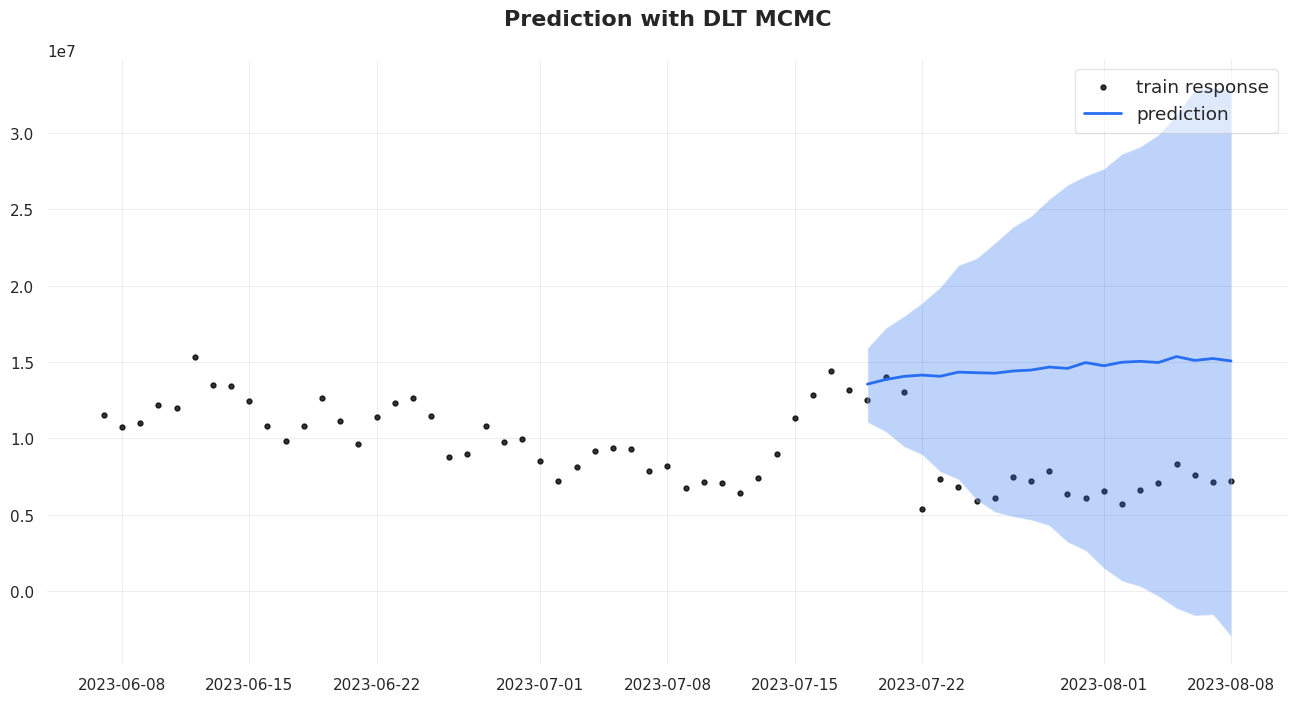

In [27]:
predicted_mcmc = dlt_mcmc.predict(df=actions_test, decompose=True)

_ = plot_predicted_data(activity, #изначальные данные
                        predicted_mcmc, #датафрейм с предсказаниями
                        "day", #колонка со временем
                        'count_actions', #колонка со значениями временного ряда
                        title='Prediction with DLT MCMC') #заголовок рисунка

## Вывод по модели MCMC
Согласно графику, предсказание на 3 недели хорошо ложится на тестовую группу. Меньше дней с понижением метрики не укладываются в рамках доверительного интервала по сравнению с предыдущим предсказанием. Но доверительный интервал увеличился.

### Дополнительно: проверка MCMC

Хотя MCMC и является более точным методам, он также более требователен к настройке параметров и соблюдению допущений. Им можно проверять графически для разных параметров - главное смотреть на глобальные показатели!

In [28]:
params = dlt_mcmc.get_posterior_samples(permute=False) #достаём информацию о параметрах

params.keys() #их названия - можно залезть в оригинальный код на Stan, чтобы вычислить их значение

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

In [29]:
params["obs_sigma"].shape #лучше смотреть те, у которых третьего измерения либо нет, либо оно равно 1

(4, 250)

Есть очень много разных вариантов проверок, реализованных в библиотеке Arviz. Есть очень много разных интересных диагностик, но самая важная их них - сходимость цепей. Визуально она должна выглядеть как 4 временных ряда, скачущих вокург примерно одного значения. Это значит, что разные инстанции алгоритма пришли к одному и тому же выводу в плане параметров!

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

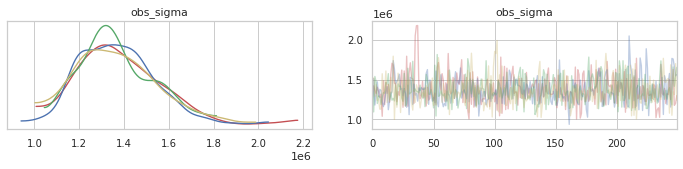

In [30]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

### Проверка сходимости целей пройдена успешно.

### Регрессоры в моделях
Если мы хотим предсказывать что-то вместе с регрессорами, мы должны знать будущие значения этих регрессоров - иначе ничего не заработает. Единственной регрессор, который возможно может повлиять на прогноз это 1 сентября - начало учебного года у детей (или другая дата в соответсвующей стране). Но как его проверить на тестовой группе, подобных явлений не было за период наблюдений. И не ясно, как именно может сработать данное предположение в "+" или "-". И он попадает на окончание 3 недели, на которые мы можем имееть достоверный прогноз с большей вероятностью.

Попробуем взять DAU - количество уникальных пользователей каждый день. Вряд ли мы будем заранее это знать, но интересно посмотреть взаимосвязь.

In [31]:
query = '''
SELECT 
    toDate(time) day,
    uniqExact(user_id) AS DAU
FROM simulator_20230720.feed_actions
WHERE toDate(time) between toDate('2023-06-07') and toDate('2023-08-08')
GROUP BY day
ORDER BY day
'''

dau = ph.read_clickhouse(query=query, connection=connection)
dau.head(7)

,day,DAU
0,2023-06-07,4617
1,2023-06-08,4728
2,2023-06-09,4890
3,2023-06-10,5878
4,2023-06-11,6771
5,2023-06-12,7667
6,2023-06-13,7773


<Axes: xlabel='day', ylabel='DAU'>

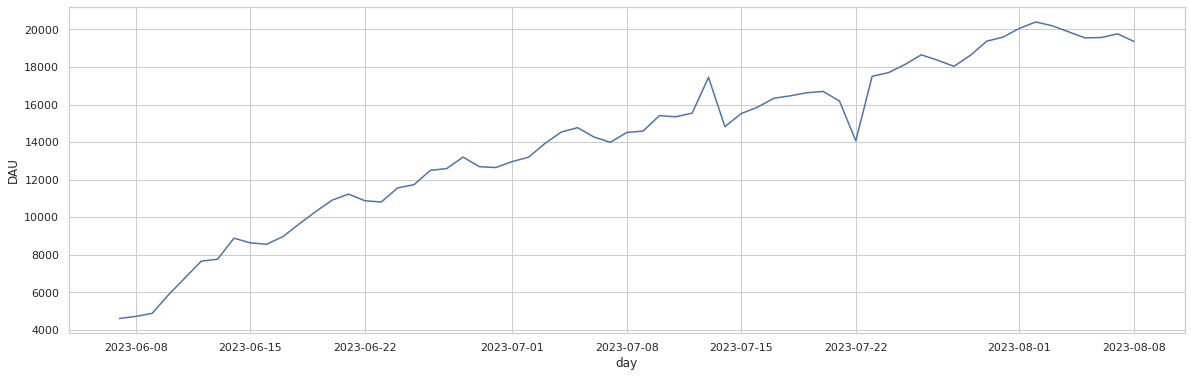

In [32]:
sns.lineplot(x='day', y='DAU', data=dau)

In [33]:
#делаем общий датафрейм
data_reg = activity.merge(dau)
data_reg

,day,count_actions,DAU
0,2023-06-07,11526051,4617
1,2023-06-08,10742321,4728
2,2023-06-09,11033173,4890
3,2023-06-10,12157657,5878
4,2023-06-11,11982134,6771
...,...,...,...
58,2023-08-04,7057448,19878
59,2023-08-05,8327623,19554
60,2023-08-06,7576892,19572
61,2023-08-07,7158693,19768


In [34]:
#посмотрим на корреляцию между ними
data_reg.drop("day", axis=1).corr()

,count_actions,DAU
count_actions,1.000000,-0.613685
DAU,-0.613685,1.000000


In [35]:
data_reg.drop("day", axis=1).corr(method="spearman") 

,count_actions,DAU
count_actions,1.000000,-0.626248
DAU,-0.626248,1.000000


In [37]:
reg_train = data_reg.query("day <= '2023-07-18'")
reg_test = data_reg.query("day > '2023-07-18'").astype({"DAU":"int64"}) #а это будем предсказывать - важно сконвертировать в int

In [38]:
reg_mcmc = DLT(seasonality=7,
               response_col="count_actions", 
               date_col="day", 
               estimator='stan-mcmc', 
               num_warmup=2000,
               num_sample=1000, 
               regressor_col=["DAU"] #наша колонка с регрессором! Должна быть списком
              ) 

reg_mcmc.fit(reg_train)

2023-09-06 09:54:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [42]:
predicted_df_reg = reg_mcmc.predict(df=reg_test, decompose=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

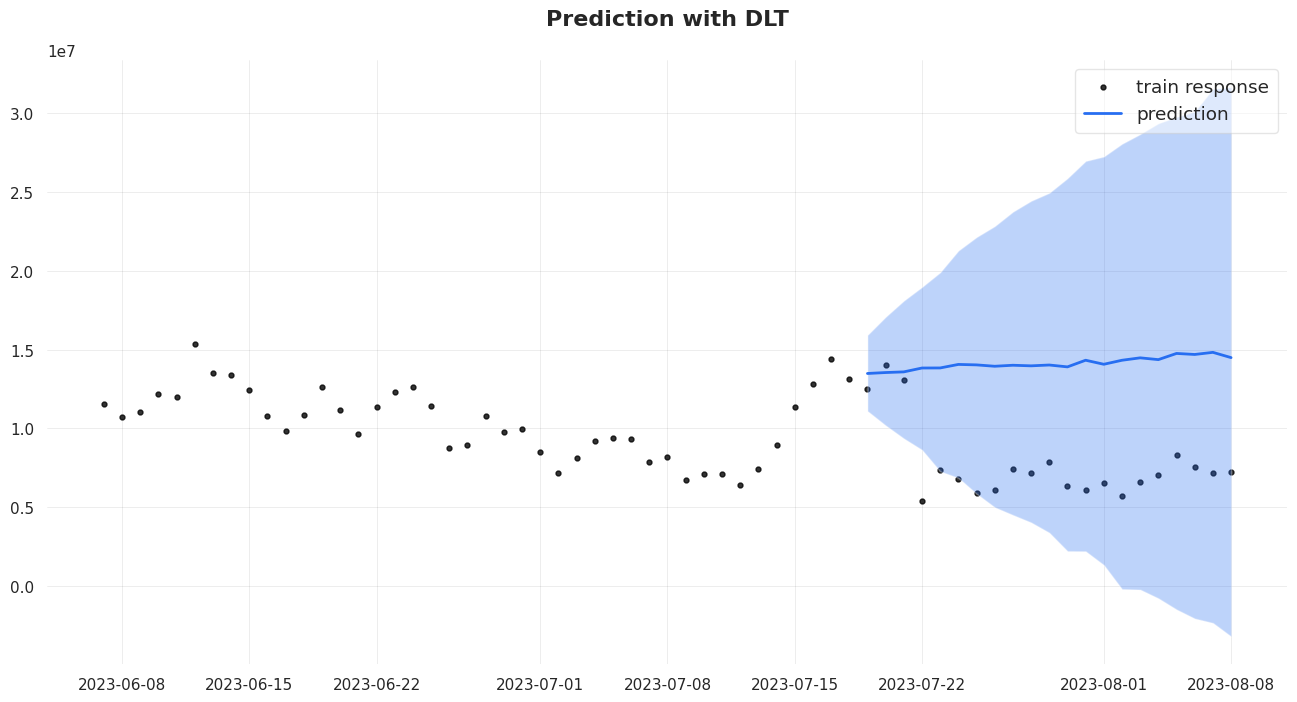

In [44]:
_ = plot_predicted_data(data_reg, predicted_df_reg, "day", 'count_actions', title='Prediction with DLT') 

Прогноз не отражает сезонность - прогноз ровной линией. Доверительный интервал больше. Но только один день не входит в доверительный интервал.

### Регуляризация

In [45]:
reg_model_auto = DLT(seasonality=7, 
                     response_col="count_actions", 
                     date_col="day", 
                     estimator='stan-mcmc',
                     num_warmup=2000,
                     num_sample=1000,
                     regressor_col=["DAU"], 
                     regression_penalty="auto_ridge" #наш новый параметр
                    ) 

In [46]:
reg_model_auto.fit(reg_train)

2023-09-06 10:00:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [47]:
predicted_df_auto = reg_model_auto.predict(df=reg_test)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

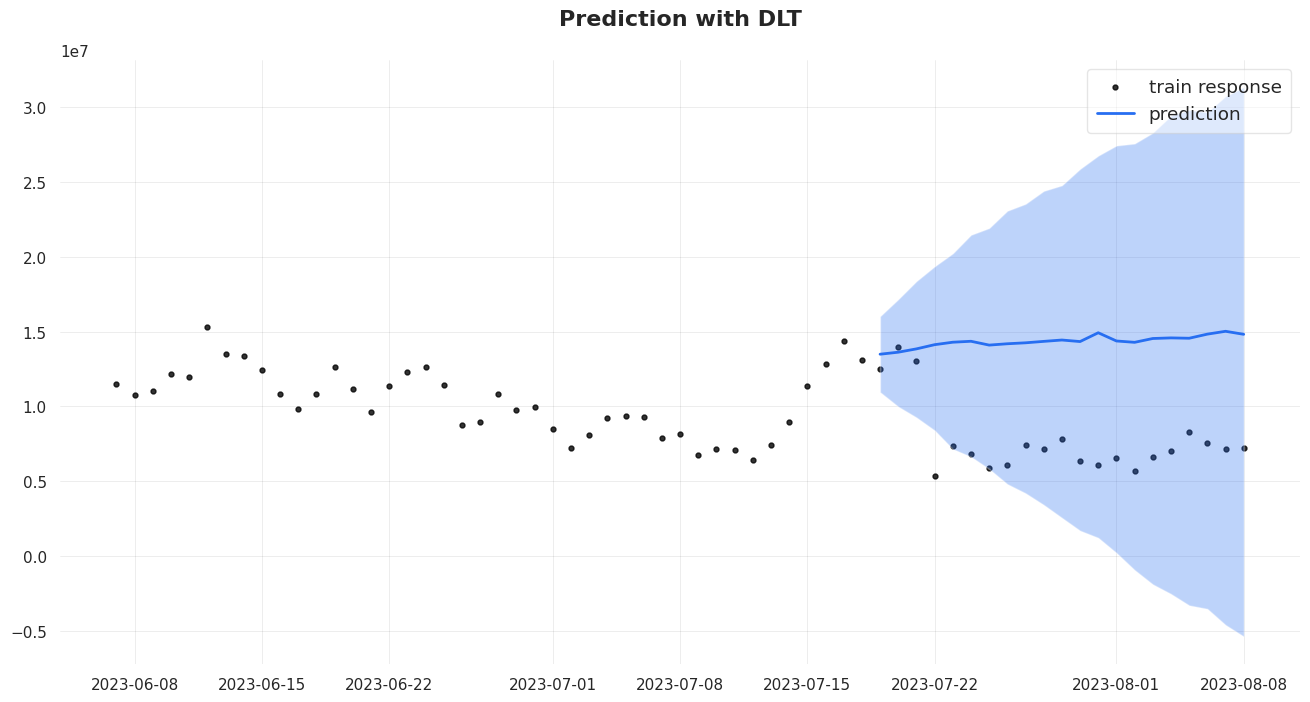

In [48]:
_ = plot_predicted_data(data_reg, predicted_df_auto, "day", 'count_actions', title='Prediction with DLT') 

In [50]:
reg_model_auto.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,DAU,Regular,0.001583,-1.453885,1.636269,0.501,0.499


Аналогично с предыдущим прогнозом. Прогноз не отражает сезонность - прогноз ровной линией. Доверительный интервал больше. Но только один день не входит в доверительный интервал.

## Посмотрим на RMSE всех моделей

In [51]:
from orbit.diagnostics.metrics import rmsse

In [53]:
print(f"RMSE map: {rmsse(actions_test.count_actions.values, predicted_df_map.prediction.values, actions_train.count_actions.values)}")
print(f"RMSE mcmc: {rmsse(actions_test.count_actions.values, predicted_mcmc.prediction.values, actions_train.count_actions.values)}")
print(f"С регрессором: {rmsse(reg_test.count_actions.values, predicted_df_reg.prediction.values, reg_train.count_actions.values)}")
print(f"С auto-ridge: {rmsse(reg_test.count_actions.values, predicted_df_auto.prediction.values, reg_train.count_actions.values)}")

RMSE map: 3.02381694251326
RMSE mcmc: 3.761708624883574
С регрессором: 3.5325150139406496
С auto-ridge: 3.6482387991298197


### Вывод:
Наименьший показатель у модели MAP. На ней и будем выполнять прогноз.

## Прогноз на 3 недели

In [54]:
# Определяем параметры модели
dlt_map = DLT(response_col="count_actions", #название колонки с метрикой
          date_col="day", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2023-09-06 10:10:18 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [55]:
# Обучаем модель:
dlt_map.fit(activity)

In [56]:
future_df = dlt_map.make_future_df(periods=7*3)

# прогнозируем
predict_map = dlt_map.predict(df=future_df, decompose=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

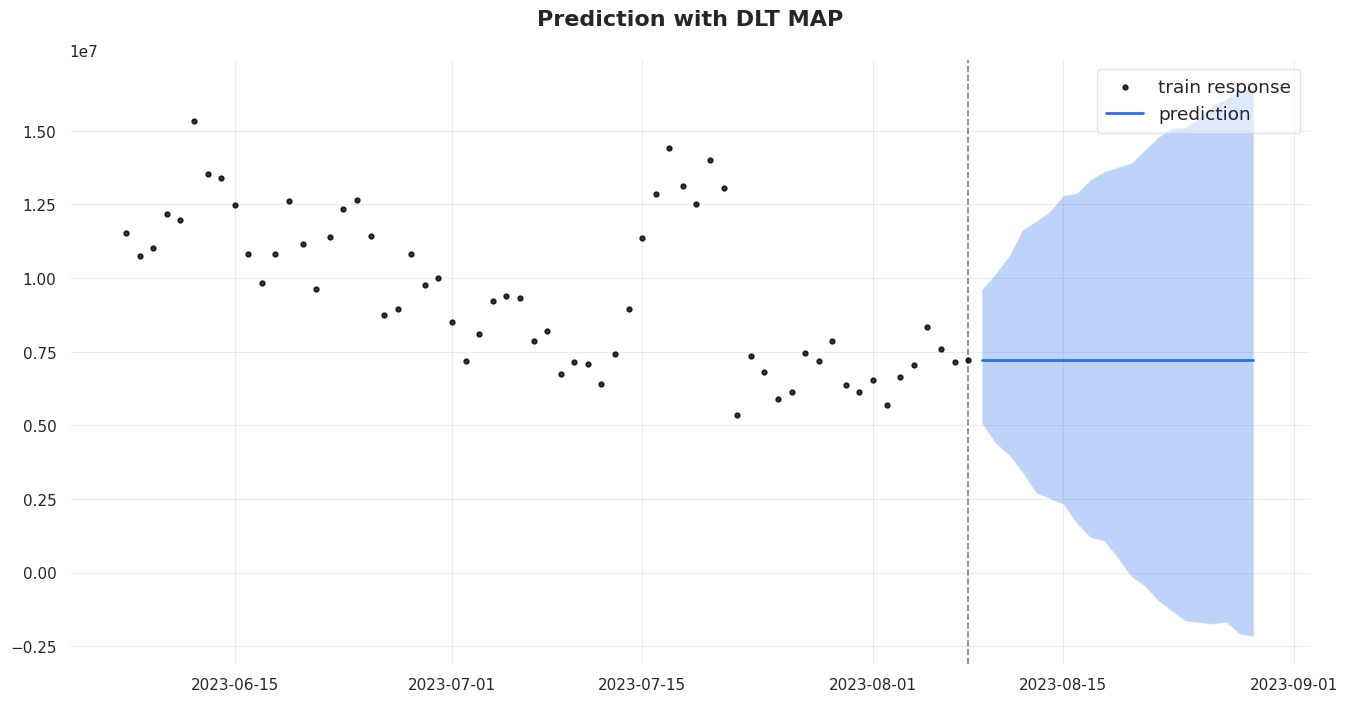

In [57]:
# Рисуем прогноз
_ = plot_predicted_data(activity, #изначальные данные
                        predict_map, #датафрейм с предсказаниями
                        "day", #колонка со временем
                        'count_actions', #колонка со значениями временного ряда
                        title='Prediction with DLT MAP') #заголовок рисунка

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

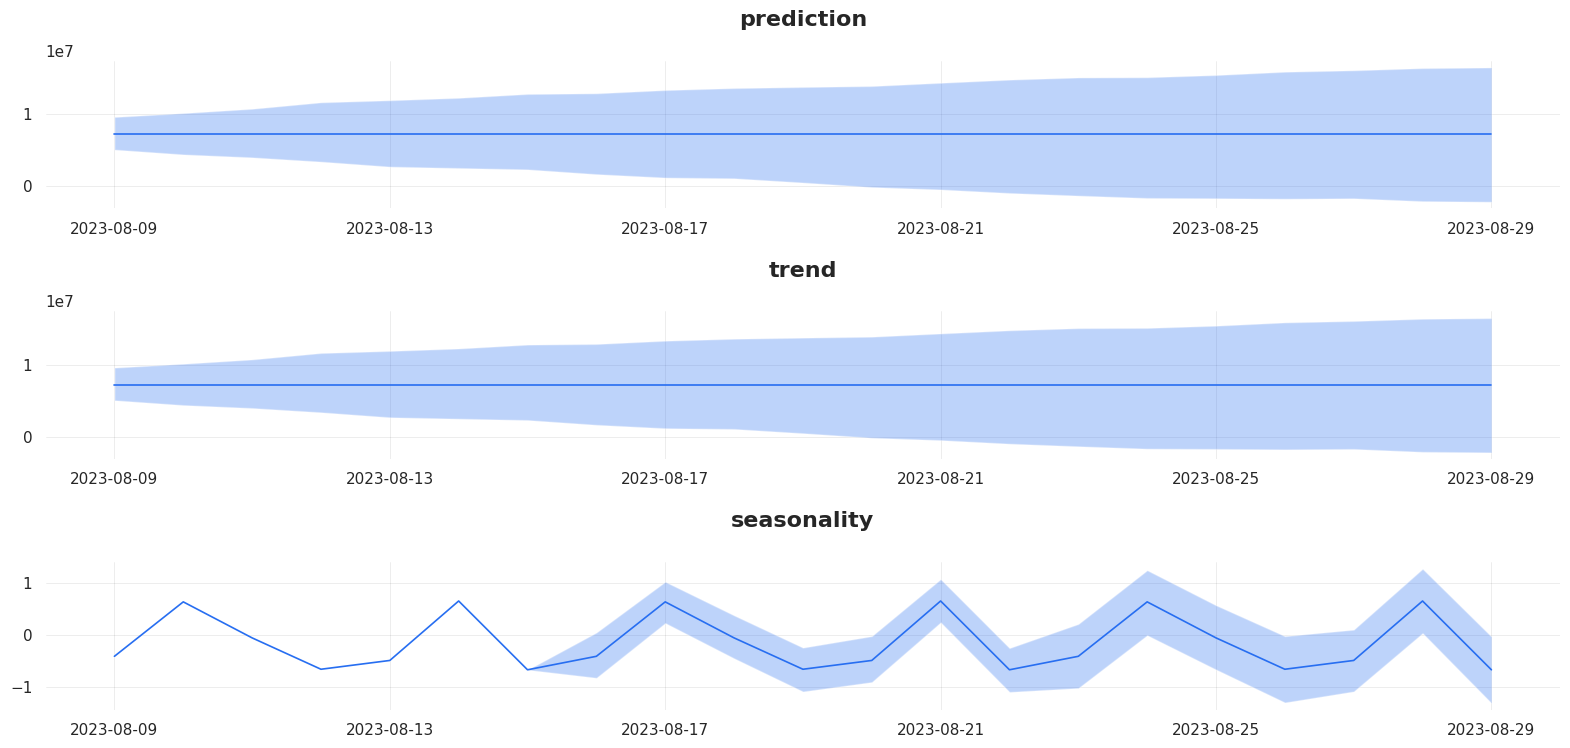

In [58]:
_ = plot_predicted_components(predict_map, 
                              "day", 
                              plot_components=['prediction', 'trend', 'seasonality'])

In [59]:
predict_map.iloc[20]

day               2023-08-29 00:00:00
prediction_5           -2166188.87222
prediction             7224509.191958
prediction_95         16475661.549345
trend_5                -2166188.69726
trend                  7224509.855037
trend_95              16475661.574422
seasonality_5               -1.298896
seasonality                 -0.663079
seasonality_95               -0.02891
regression_5                      0.0
regression                        0.0
regression_95                     0.0
Name: 20, dtype: object

In [62]:
# изменение действий в процентах
round(predict_map.iloc[20]['prediction'] / activity["count_actions"].max(), 2) * 100 - 100

-53.0

In [63]:
round(predict_map.iloc[20]['prediction_95'] / activity["count_actions"].max(), 2) * 100 - 100

7.0

### Вывод:
Согласно проведенному испытанию ожидаемое значение ежедневного количества действий через 3 недели 2023-08-29 составляет:
prediction = 7224509.191958, prediction_95 = 16475661.549345, т.е. количество действий увеличется не более, чем на 7% относительно максимального значения количества действий.

Посмотрим что спрогнозируем через 1 месяц.

## Прогноз на 1 месяц

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

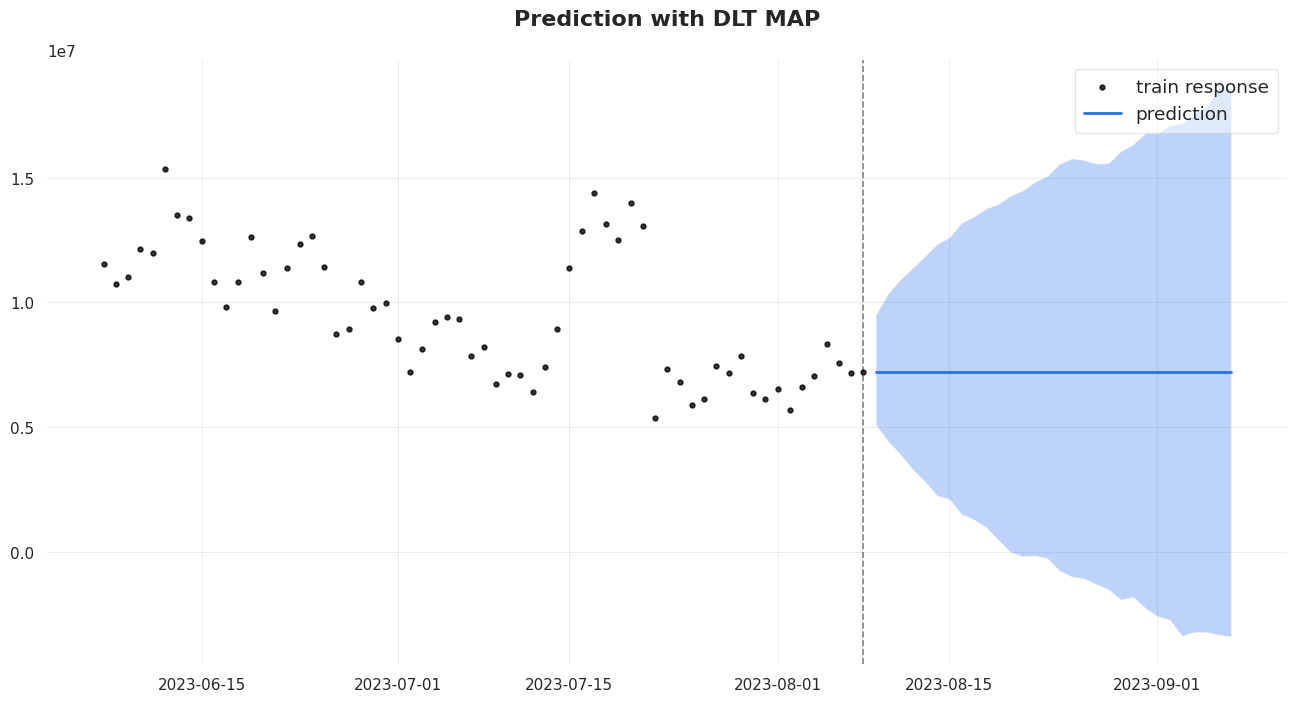

In [69]:
future_df_2 = dlt_map.make_future_df(periods=30)
predict_map_2 = dlt_map.predict(df=future_df_2, decompose=True)

_ = plot_predicted_data(activity, #изначальные данные
                        predict_map_2, #датафрейм с предсказаниями
                        "day", #колонка со временем
                        'count_actions', #колонка со значениями временного ряда
                        title='Prediction with DLT MAP') #заголовок рисунка

In [70]:
predict_map_2.iloc[29]

day               2023-09-07 00:00:00
prediction_5           -3383857.42362
prediction             7224509.586721
prediction_95          18573067.32197
trend_5               -3383857.435611
trend                  7224508.953513
trend_95              18573066.075114
seasonality_5               -0.236566
seasonality                  0.633208
seasonality_95                1.55736
regression_5                      0.0
regression                        0.0
regression_95                     0.0
Name: 29, dtype: object

In [71]:
activity["count_actions"].max()

15338850

In [72]:
# увеличение DAU в процентах
round(predict_map_2.iloc[29]['prediction'] / activity["count_actions"].max(), 2) * 100 - 100

-53.0

In [73]:
round(predict_map_2.iloc[29]['prediction_95'] / activity["count_actions"].max(), 2) * 100 - 100

21.0

### Вывод:
Согласно проведенному испытанию ожидаемое значение ежедневного количества действий через 3 недели 2023-08-29 составляет:
prediction = 7224509.586721, prediction_95 = 18573067.32197, т.е. количество действий увеличется не более, чем на 21% относительно максимального значения количества действий.